### import

In [1]:
import os
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import monai
from monai import transforms
from monai.utils import set_determinism, first
from monai.transforms import(
    AsDiscrete,
    AddChanneld,
    Compose,
    CropForegroundd,
    EnsureChannelFirstd,
    LoadImaged,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandSpatialCropSamplesd,
    RandShiftIntensityd,
    RandZoomd,
    ScaleIntensityd,
    Spacingd,
    SpatialPadd,
    GaussianSmoothd,
    RandRotate90d,
    ToTensord,
    RandSpatialCropd,
    RandGaussianSmoothd,    
    RandGaussianSharpend,
    RandGaussianNoise,
    RandGaussianNoised,
    
)
from generative.losses import PatchAdversarialLoss, PerceptualLoss
from monai.config import print_config
from monai.losses import DiceCELoss
from monai.metrics import DiceMetric

from monai.data import (
    DataLoader,
    Dataset,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)
from monai.networks.nets import UNet
from skimage import measure
from sklearn.metrics import roc_auc_score

import torch
import glob
print_config()

Failed to load image Python extension: /home/hufsbme/anaconda3/envs/infant/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE


MONAI version: 1.2.dev2304
Numpy version: 1.23.5
Pytorch version: 1.13.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 9a57be5aab9f2c2a134768c0c146399150e247a0
MONAI __file__: /home/hufsbme/.local/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
ITK version: 5.3.0
Nibabel version: 5.0.0
scikit-image version: 0.19.3
Pillow version: 9.3.0
Tensorboard version: 2.12.3
gdown version: 4.6.0
TorchVision version: 0.13.1a0
tqdm version: 4.64.1
lmdb version: 1.4.0
psutil version: 5.9.0
pandas version: 1.5.3
einops version: 0.6.0
transformers version: 4.21.3
mlflow version: 2.1.1
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [2]:

from models.network_swinir import SwinIR as net


In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print(device)

cuda:0


In [ ]:
!nvidia-smi

### data

In [4]:
import os
import glob
data_dir =  glob.glob('/nfs/hufsaims/kjh_shared/euna/data_bcp/*/*/3D_T2_*.nii.gz')
data_dir2 = glob.glob('/nfs/hufsaims/kjh_shared/euna/data_bcp/resolution_down//T2_*.nii.gz')
data_size = len(data_dir) #26
train = int(data_size*0.9)
data_dir
data_dir2

['/nfs/hufsaims/kjh_shared/euna/data_bcp/resolution_down/T2_0.nii.gz',
 '/nfs/hufsaims/kjh_shared/euna/data_bcp/resolution_down/T2_1.nii.gz',
 '/nfs/hufsaims/kjh_shared/euna/data_bcp/resolution_down/T2_2.nii.gz',
 '/nfs/hufsaims/kjh_shared/euna/data_bcp/resolution_down/T2_3.nii.gz',
 '/nfs/hufsaims/kjh_shared/euna/data_bcp/resolution_down/T2_4.nii.gz',
 '/nfs/hufsaims/kjh_shared/euna/data_bcp/resolution_down/T2_5.nii.gz',
 '/nfs/hufsaims/kjh_shared/euna/data_bcp/resolution_down/T2_6.nii.gz',
 '/nfs/hufsaims/kjh_shared/euna/data_bcp/resolution_down/T2_7.nii.gz',
 '/nfs/hufsaims/kjh_shared/euna/data_bcp/resolution_down/T2_8.nii.gz',
 '/nfs/hufsaims/kjh_shared/euna/data_bcp/resolution_down/T2_9.nii.gz',
 '/nfs/hufsaims/kjh_shared/euna/data_bcp/resolution_down/T2_10.nii.gz',
 '/nfs/hufsaims/kjh_shared/euna/data_bcp/resolution_down/T2_11.nii.gz',
 '/nfs/hufsaims/kjh_shared/euna/data_bcp/resolution_down/T2_12.nii.gz',
 '/nfs/hufsaims/kjh_shared/euna/data_bcp/resolution_down/T2_13.nii.gz',
 '

In [ ]:
len(data_dir),len(data_dir2)

In [5]:
train_ind = np.arange(0, 1)
#basal bcp : 123-150
#random으로 n
#cmcep

data_dicts = [
    {
        'image' : data_dir[i],
        'low_res_image' : data_dir2[i]
        
    }for i in train_ind
]
train_data = data_dicts

valid_ind = np.arange(0, 1)
#valid_ind = np.arange(25, 34)
data_dicts = [
    {
        'image' : data_dir[i],
        'low_res_image': data_dir2[i]
         
    }for i in valid_ind
]
valid_data = data_dicts

## transform & dataloader

In [6]:
train_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image",'low_res_image']),
        transforms.EnsureChannelFirstd(keys=["image","low_res_image"]),
        transforms.ScaleIntensityd(
                keys=["image",'low_res_image'],
                minv=0.0,
                maxv=1.0,
        ),           
#         RandZoomd(
#             keys=["image", "low_res_image"],
#             prob = 0.5,
#             min_zoom = .8,
#             max_zoom = 1.25,
#             mode = ['area','nearest']
#         ),
#         RandGaussianNoised(keys = ['image','low_res_image'], prob= .333, mean = 0, std = 0.01),

#         transforms.SpatialPadd(keys=['image','low_res_image'],spatial_size=(256,256,256)),
        transforms.CenterSpatialCropd(keys=['image','low_res_image'],roi_size = (192,192,192)),
#         transforms.RandRotated(keys = ['image','low_res_image'],prob=0.5,range_x=[0.25,0.25])

    ]
)
train_ds = CacheDataset(data=train_data, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=4, persistent_workers=True)

Loading dataset: 100%|████████████████████████████| 1/1 [00:01<00:00,  1.26s/it]


Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


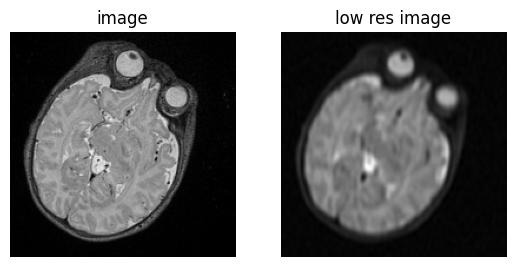

In [7]:
check_data = first(train_loader)
fig, ax = plt.subplots(nrows=1,ncols=3)
for i in range(1):
    plt.subplot(121)
    plt.title('image')
    plt.imshow(check_data['image'][i,0,:,100,:],cmap = 'gray')
    plt.axis('off')
    plt.subplot(122)
    plt.title('low res image')
    plt.imshow(check_data['low_res_image'][i,0,:,100,:],cmap = 'gray')
    plt.axis('off')
    plt.show()
  

In [10]:
check_data['low_res_image'].size()

torch.Size([1, 1, 192, 192, 192])

In [ ]:
# # import nibabel as nib
# for i in range(len(data_dir)):
#     nifti_img = nib.load(data_dir[i])
#     image = nifti_img.get_fdata()
#     image2= nib.load(data_dir2[i])
#     image2 = image2.get_fdata() #208,320,320
    
#     plt.subplot(121)
#     plt.imshow(image[:,150,:],cmap='gray')
#     plt.subplot(122)
#     plt.imshow(image2[:,150,:],cmap='gray')
#     plt.show()

In [ ]:
!nvidia-smi

## validation

In [ ]:
val_transforms = transforms.Compose(
    [
          transforms.LoadImaged(keys=["image",'low_res_image']),
        transforms.EnsureChannelFirstd(keys=["image","low_res_image"]),
        transforms.ScaleIntensityd(
                keys=["image",'low_res_image'],
                minv=0.0,
                maxv=1.0,
        ),           
#         transforms.SpatialPadd(keys=['image','low_res_image'],spatial_size=(256,256,256)),
        transforms.CenterSpatialCropd(keys=['image','low_res_image'],roi_size = (192,192,192)),
    ]
)
val_ds = CacheDataset(data=valid_data, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=2, shuffle=True, num_workers=4)

In [ ]:
check_data = first(val_loader)
fig, ax = plt.subplots(nrows=1,ncols=3)
for i in range(1):
    plt.subplot(121)
    plt.title('image')
    plt.imshow(check_data['image'][i,0,:,100,:],cmap = 'gray')
    plt.subplot(122)
    plt.title('low res image')
    plt.imshow(check_data['low_res_image'][i,0,:,100,:],cmap = 'gray')
    plt.axis('off')
    plt.show()
  

In [ ]:
check_data['image'].shape

In [ ]:
#60-100
plt.subplot(1,4,1)
plt.imshow(check_data['image'][0,0,:,100,:],cmap = 'gray')
plt.subplot(1,4,2)
plt.imshow(check_data['image'][0,0,:,80,:],cmap = 'gray')
plt.subplot(1,4,3)

plt.imshow(check_data['image'][0,0,:,70,:],cmap = 'gray')
plt.subplot(1,4,4)

plt.imshow(check_data['image'][0,0,:,30,:],cmap = 'gray')
plt.show()

## Model

In [ ]:

def get_outnorm(x:torch.Tensor, out_norm:str='') -> torch.Tensor:
    """ Common function to get a loss normalization value. Can
        normalize by either the batch size ('b'), the number of
        channels ('c'), the image size ('i') or combinations
        ('bi', 'bci', etc)
    """
    # b, c, h, w = x.size()
    img_shape = x.shape

    if not out_norm:
        return 1

    norm = 1
    if 'b' in out_norm:
        # normalize by batch size
        # norm /= b
        norm /= img_shape[0]
    if 'c' in out_norm:
        # normalize by the number of channels
        # norm /= c
        norm /= img_shape[-3]
    if 'i' in out_norm:
        # normalize by image/map size
        # norm /= h*w
        norm /= img_shape[-1]*img_shape[-2]

    return norm

In [ ]:
class CharbonnierLoss(torch.nn.Module):
    """Charbonnier Loss (L1)"""
    def __init__(self, eps=1e-6, out_norm:str='bci'):
        super(CharbonnierLoss, self).__init__()
        self.eps = eps
        self.out_norm = out_norm

    def forward(self, x, y):
        norm = get_outnorm(x, self.out_norm)
        loss = torch.sum(torch.sqrt((x - y).pow(2) + self.eps**2))
        return loss*norm

In [ ]:
# model = monai.networks.nets.UNet(
#         spatial_dims=2,
#         in_channels=7,
#         out_channels=1,
#         channels=(64, 128, 256, 512),
#         strides=(2, 2, 2),
#         num_res_units=3,
#     ).to(device)
model = net(upscale=1, in_chans=7, img_size=192, window_size=4,
                    img_range=1., depths=[3, 3, 3], embed_dim=90, num_heads=[3, 3,3],
                    mlp_ratio=2, upsampler='', resi_connection='1conv').to(device)
loss_function = CharbonnierLoss()
optimizer = torch.optim.AdamW(model.parameters(), 1e-4)
# model.load_state_dict(torch.load(os.path.join("./High_res_UNet_v5.pth")))

In [ ]:
def validation(val_loader):
    model.eval()
    with torch.no_grad():
        for step,batch in tqdm(enumerate(val_loader)):
#             rand = random.randint(30,100)
            rand= 70
            images = batch['low_res_image']
            images = images.squeeze(1)
            images = images[...,rand:rand+7,:].to(device)
            images = images.permute(0,2,1,3)

            target = batch['image'][...,rand+3,:].to(device)
            
            val_output = model(images)

            loss = loss_function(val_output,target)
    plt.subplot(131)
    plt.imshow(images[0,4,...].detach().cpu(),cmap='gray')
    plt.axis('off')
    plt.title('input')

    plt.subplot(132)
    plt.imshow(target[0,0,...].detach().cpu(),cmap='gray')
    plt.axis('off')
    plt.title('gt')

    plt.subplot(133)
    plt.imshow(val_output[0,0,...].detach().cpu(),cmap='gray')
    plt.title('prediction')

    plt.axis('off')
    plt.show()
    return loss.item()
    

In [ ]:
#60-110 슬라이스 쓰기
train_loss = []
val_loss = []
dice_val_best = 100
dice_val = 0
for epoch in range(7000):
    epoch_loss = 0
    model.train()
    for step,batch in tqdm(enumerate(train_loader)):
#         rand = random.randint(30,100) 
        rand= 70
        images = batch['low_res_image']
        images = images.squeeze(1)
        images = images[...,rand:rand+7,:].to(device)
        images = images.permute(0,2,1,3)
        
        target = batch['image'][...,rand+3,:].to(device)
        
        output = model(images)
        optimizer.zero_grad()
        
        loss = loss_function(output,target)
        
        loss.backward()
        
        epoch_loss += loss.item()
        
        optimizer.step()
        
    train_loss.append(epoch_loss/(step+1))
    print(f'Epoch {epoch+1}, Loss: {epoch_loss/len(train_loader)}')
    if epoch % 50 == 0:
        dice_val = validation(val_loader)
        dice_val = (dice_val/len(val_loader))
        val_loss.append(dice_val)
        
        plt.subplot(121)
        plt.plot(train_loss,label='train')
        plt.legend(loc='lower left')
        plt.subplot(122)
        plt.plot(val_loss,label='valid')
        plt.legend(loc='lower left')
        plt.title('Loss Curve')
        plt.show()
    
        if dice_val < dice_val_best:
            dice_val_best = dice_val
            torch.save(model.state_dict(),os.path.join(f'./SwinUNetIR_v4.pth'))
            print(f'Model was saved! Current Best Dice {dice_val_best}')

   
        
        

In [ ]:
model = monai.networks.nets.UNet(
        spatial_dims=2,
        in_channels=7,
        out_channels=1,
        channels=(64, 128, 256, 512),
        strides=(2, 2, 2),
        num_res_units=3,
    ).to(device)
# loss_function = torch.nn.L1Loss()
# mseloss = torch.nn.MSELoss()
# perceptual_loss = PerceptualLoss(spatial_dims = 2,network_type = 'alex').to(device)

optimizer = torch.optim.AdamW(model.parameters(), 1e-4)

In [ ]:
def validation(val_loader):
    model.eval()
    with torch.no_grad():
        for step,batch in tqdm(enumerate(val_loader)):
#             rand = random.randint(30,100)
            rand= 70
            images = batch['low_res_image']
            images = images.squeeze(1)
            images = images[...,rand:rand+7,:].to(device)
            images = images.permute(0,2,1,3)

            target = batch['image'][...,rand+3,:].to(device)
            
            val_output = model(images)

            loss = loss_function(val_output,target)
    plt.subplot(131)
    plt.imshow(images[0,4,...].detach().cpu(),cmap='gray')
    plt.axis('off')
    plt.title('input')

    plt.subplot(132)
    plt.imshow(target[0,0,...].detach().cpu(),cmap='gray')
    plt.axis('off')
    plt.title('gt')

    plt.subplot(133)
    plt.imshow(val_output[0,0,...].detach().cpu(),cmap='gray')
    plt.title('prediction')

    plt.axis('off')
    plt.show()
    return loss.item()

In [ ]:
# 60-110 슬라이스 쓰기
train_loss = []
val_loss = []
dice_val_best = 100
dice_val = 0
for epoch in range(1000):
    epoch_loss = 0
    model.train()
    for step,batch in tqdm(enumerate(train_loader)):
#         rand = random.randint(30,100) 
        rand= 70
        images = batch['low_res_image']
        images = images.squeeze(1)
        images = images[...,rand:rand+7,:].to(device)
        images = images.permute(0,2,1,3)
        
        target = batch['image'][...,rand+3,:].to(device)
        
        output = model(images)
        optimizer.zero_grad()
        
        loss = loss_function(output,target)
        
        loss.backward()
        
        epoch_loss += loss.item()
        
        optimizer.step()
        
    train_loss.append(epoch_loss/(step+1))
    print(f'Epoch {epoch+1}, Loss: {epoch_loss/len(train_loader)}')
    if epoch % 50 == 0:
        dice_val = validation(val_loader)
        dice_val = (dice_val/len(val_loader))
        val_loss.append(dice_val)
        
        plt.subplot(121)
        plt.plot(train_loss,label='train')
        plt.legend(loc='lower left')
        plt.subplot(122)
        plt.plot(val_loss,label='valid')
        plt.legend(loc='lower left')
        plt.title('Loss Curve')
        plt.show()
    
        if dice_val < dice_val_best:
            dice_val_best = dice_val
#             torch.save(model.state_dict(),os.path.join(f'./UNet_test.pth'))
            print(f'Model was saved! Current Best Dice {dice_val_best}')

   

In [ ]:
model.load_state_dict(torch.load(os.path.join('./SwinUNetIR_v3.pth')))

In [ ]:
model.eval()
with torch.no_grad():
    for step,batch in tqdm(enumerate(val_loader)):
        rand = random.randint(60,100)
        images = batch['low_res_image']
        images = images.squeeze(1)
        images = images[...,rand:rand+7,:].to(device)
        images = images.permute(0,2,1,3)

        target = batch['image'][...,rand+3,:].to(device)

        val_output = model(images)
#         loss = loss_function(val_output,target)
        plt.subplot(131)
        plt.imshow(images[0,4,...].detach().cpu(),cmap='gray',vmin=0,vmax=0.5)
        plt.axis('off')
        plt.title('input')

        plt.subplot(132)
        plt.imshow(target[0,0,...].detach().cpu(),cmap='gray',vmin=0,vmax=0.5)
        plt.axis('off')
        plt.title('gt')

        plt.subplot(133)
        plt.imshow(val_output[0,0,...].detach().cpu(),cmap='gray',vmin=0,vmax=0.5)
        plt.title('prediction')

        plt.axis('off')
        plt.show()

In [ ]:
torch.save(model.state_dict(),os.path.join(f'./High_res_UNet_v2.pth'))


In [ ]:
images.shape

In [ ]:
plt.imshow(output[0,0].detach().cpu(),vmin=0,vmax=1)
plt.colorbar()

In [ ]:
plt.imshow(images[0,3].detach().cpu(),vmin=0,vmax=.5)
plt.colorbar()